# Optimal Transport in Generative Adversarial Networks

Project part 2: **WGAN with Weight Clipping & Gradient Penalty**

----

**Author: Ashraf GHIYE**

----


# Why **Wasserstein** GAN?

Binary Cross-Entropy loss or BCE loss, is traditionally used for training GANs, but it isn't the best way to do it. With BCE loss GANs are prone to mode collapse and other problems.

Instead of using a BCE loss, we will use the Earth Moving distance, which is a measure more adapted to capture the distance between two probability distributions. What the Earth Mover's distance does, is it measures how different these two distributions are, by estimating the amount of effort it takes to make the generated distribution equal to the real. 

So intuitively, if the generated distribution was a pile of dirt, how difficult would it be to move that pile of dirt and mold it into the shape and location of the real distribution? So that's what this Earth mover's distance means. The function depends on both the distance and the amount that the generated distribution needs to be moved.

Wasserstein Loss, or W-Loss for short, approximates the Earth Mover's Distance, and solves some problems faced by GANs, like mode claps and vanishing gradients. But for it to work well, there is a special condition that needs to be met by the critic. In the original article [1](https://arxiv.org/pdf/1701.07875.pdf), to solve this condition (which is, the critic has to be 1-Lipschitz function) Arjovsky et Chintala proposed to **clip the weights** of the critic network during training to ensure that gradients will be inside a box $[-c, c]$

There's a lot of hyperparameter tuning involved. For that, the **gradient penalty**, which is another method [2](https://arxiv.org/abs/1704.00028), is a much softer way to enforce the critic to be one lipschitz continuous. With the gradient penalty, all you need to do is add a regularization term to your loss function. What this regularization term does to your W loss function, is that it penalizes the critic when it's gradient norm is higher than one. I'll dive into what that means.


# Summary

This notebook is an implementation the WGAN with weight clipping as proposed in the original article [1] and gradient penalty as proposed in [2].

Both articles use the dual formulation of Kantorovich with a slight transormation to approximate the 1-Wasserstein distance over the space of 1-Lipschitz functions. the Lipschitz function $f$ is modeled by the critic network.

However, each article propose a method to enforce the Lipschitz constraint, in [1] they propose weight clipping which is hard-enforcing while in [2] they use a much softer way by smoothing the problem and adding a penalty term in the objective function to penalize functions that are not 1-Lipschitz.

**Evaluation:**

In order to test the model, we use the MNIST digit dataset.

**Architecture:**

The architecture suggested by [1] and [2] for the MNIST dataset is that of the famous DCGAN.

<br>


---

References:

[1] Martin Arjovsky, Soumith Chintala, Léon Bottou. December 2017: **Wasserstein GAN** 

[2] Ishaan Gulrajani et al. December 2017: **Improved Training of Wasserstein GANs** 



# Wasserstein GAN with Weight Clipping

In this section, we are going to build a Wasserstein GAN with Weight Clipping [1] (WGAN) that solves some of the stability issues with the GANs (mode collapse, stability issues, etc..). 

Specifically, we will use a special kind of loss function known as the W-loss, where W stands for Wasserstein distance.


## Generator and Critic

We will begin by importing some useful packages, defining visualization functions, building the generator, and building the critic.

#### Packages and Visualizations

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

The architectures of the Generator and Critic is that of DCGAN. We only introduce the new loss W-distance instead of BCE.

#### Generator and Noise

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

#### Critic

In [ ]:
class Critic(nn.Module):
    '''
    Critic Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a critic block of DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the critic: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

## Training Initializations

We will set some hyper parameters:

  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   c_lambda: weight clipping bound
  *   crit_repeats: number of times to update the critic per generator update
  *   device: the device type

We will also load and transform the MNIST dataset to tensors.




In [ ]:
n_epochs = 100
z_dim = 100
batch_size = 64
lr = 0.00005
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 0.01
crit_repeats = 5
display_step = 128*5*10
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Then, we can initialize your generator, critic, and optimizers.

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.RMSprop(gen.parameters(), lr=lr)
crit = Critic().to(device) 
crit_opt = torch.optim.RMSprop(crit.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)


## Weight Clipping

Clipping allows us to enforce the 1-Lipschitz constraint on the critic’s model to approximate the Wasserstein distance.

$w \gets clip(w,-c,c)$

## Losses
Next, we need to calculate the loss for the generator and the critic.

For the generator, the loss is calculated by maximizing the critic's prediction on the generator's fake images.

In [ ]:
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    gen_loss = - crit_fake_pred.mean()
    return gen_loss

For the critic, the loss is calculated by maximizing the distance between the critic's predictions on the real images and the predictions on the fake images.


In [ ]:
def get_crit_loss(crit_fake_pred, crit_real_pred):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() 
    return crit_loss

## Putting It All Together
Before we put everything together, there are a few things to note.
1.   One important point is that we are going to **update the critic multiple times** every time we update the generator This helps prevent the generator from overpowering the critic.
2.   WGAN isn't necessarily meant to improve overall performance of a GAN, but just **increases stability** and avoids mode collapse. In general, a WGAN will be able to train in a much more stable way than the vanilla DCGAN. Though it will generally run a bit slower. 

Step 0: Generator loss: 1.6444060020148754e-06, critic loss: -4.935860633850098e-07


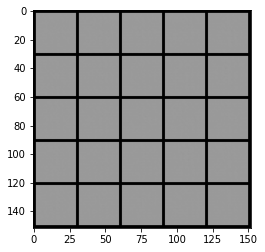

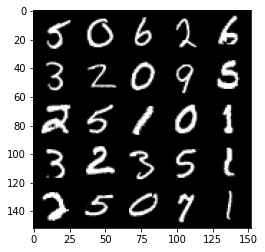

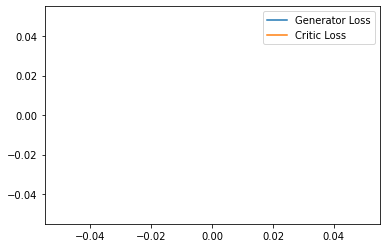

Step 6400: Generator loss: -0.012487890707002408, critic loss: -0.10901628057257008


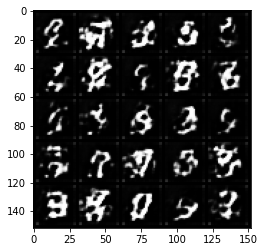

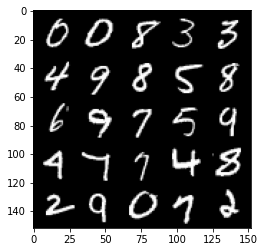

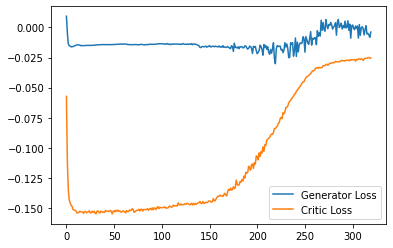

Step 12800: Generator loss: -0.005515120148800179, critic loss: -0.01830759067842156


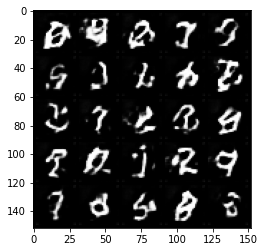

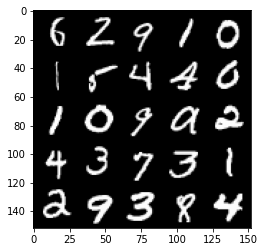

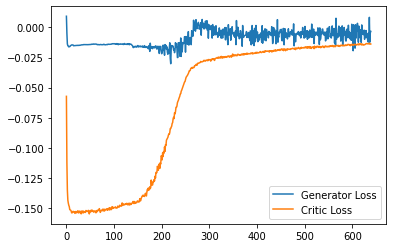

Step 19200: Generator loss: -0.0032466478561855184, critic loss: -0.01176908961498516


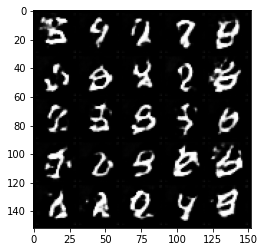

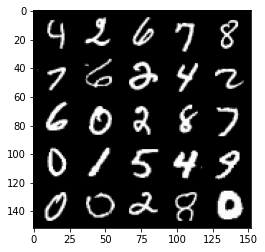

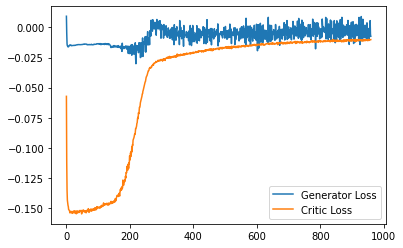

Step 25600: Generator loss: -0.0038607116694743125, critic loss: -0.009364220965519074


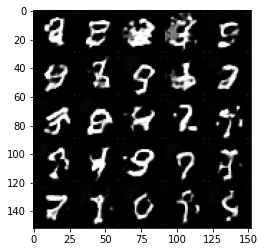

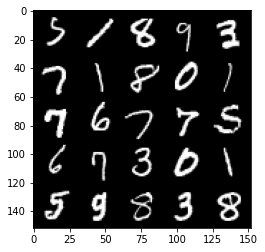

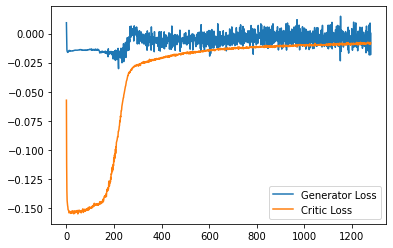

Step 32000: Generator loss: -0.003491866037109048, critic loss: -0.007862595718354012


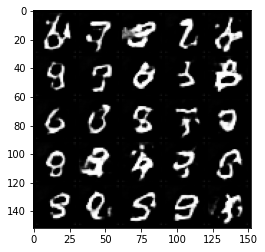

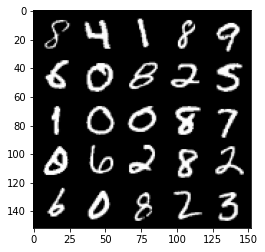

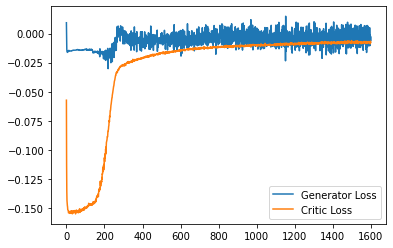

Step 38400: Generator loss: -0.0033520174661271084, critic loss: -0.007203902199403271


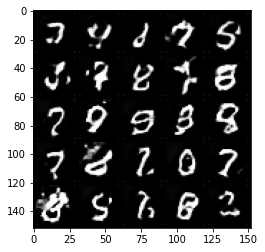

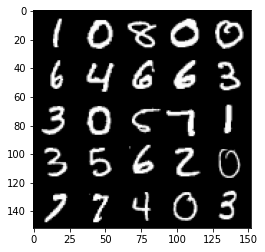

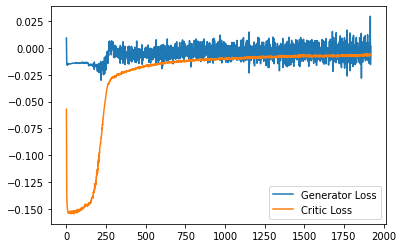

Step 44800: Generator loss: -0.0008743809052202778, critic loss: -0.006592262653223751


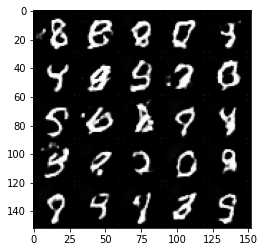

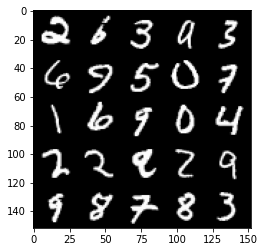

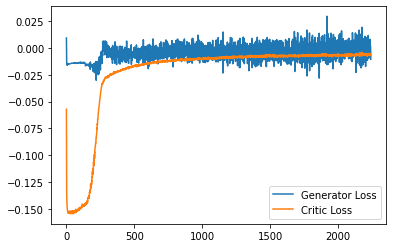

Step 51200: Generator loss: -0.000525098297941895, critic loss: -0.005576770560727696


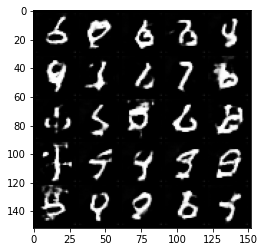

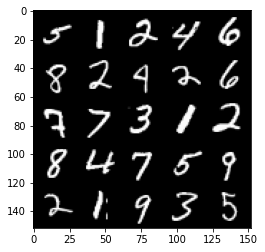

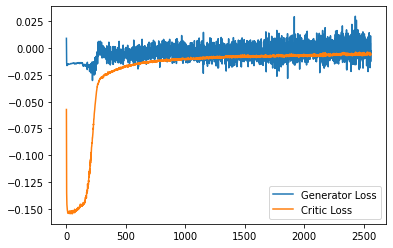

Step 57600: Generator loss: -0.0008591002046159701, critic loss: -0.004536292057930952


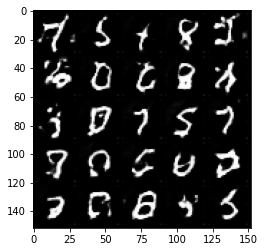

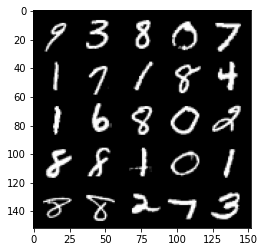

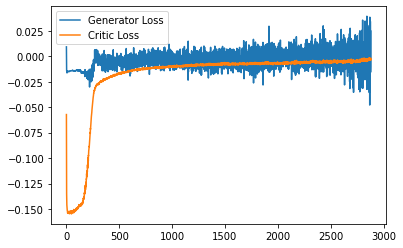

Step 64000: Generator loss: 0.004179242874261036, critic loss: -0.0025643071523409142


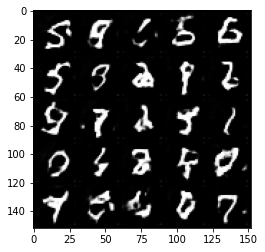

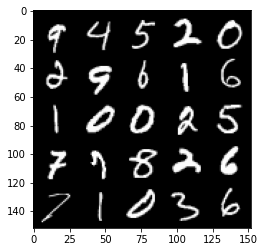

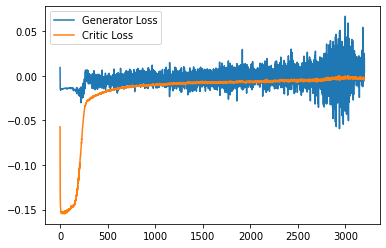

Step 70400: Generator loss: 0.007690355184593045, critic loss: -0.002867907602260864


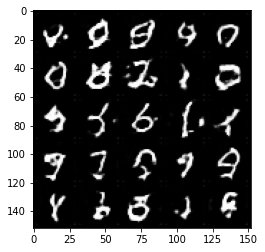

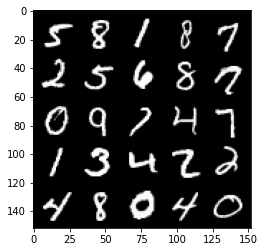

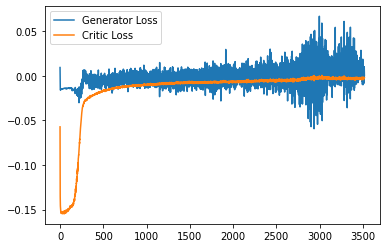

Step 76800: Generator loss: 0.009749254115363329, critic loss: -0.0023071389378696975


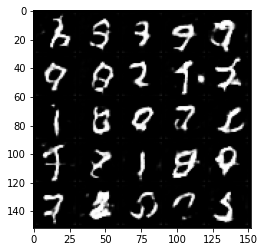

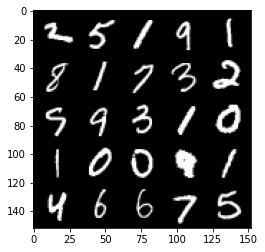

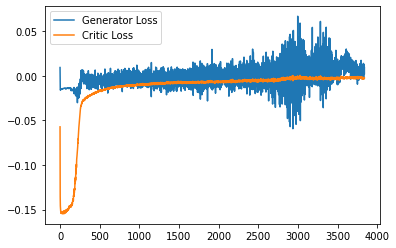

Step 83200: Generator loss: 0.008375034736470752, critic loss: -0.002809502607093234


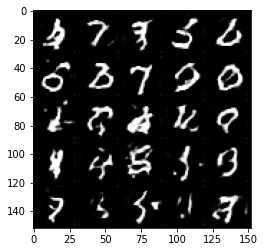

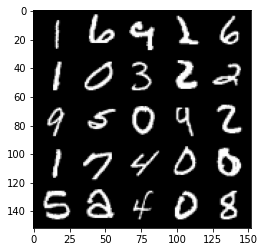

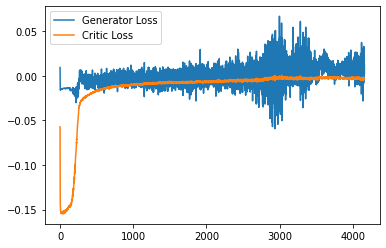

Step 89600: Generator loss: 0.009072572574441438, critic loss: -0.0026344520239244915


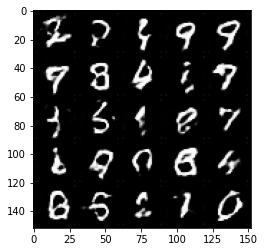

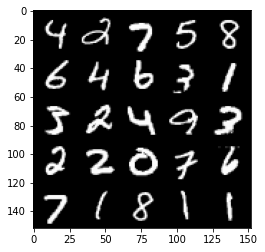

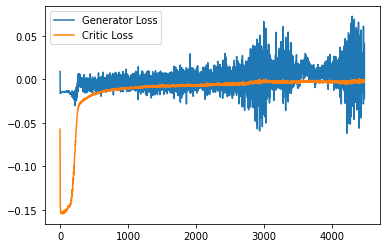

In [ ]:
import matplotlib.pyplot as plt

cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
            for p in crit.parameters():
              p.data.clamp_(-c_lambda, +c_lambda)

        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step >= 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1


## Conclusion WGAN

The difficulty in WGAN is to enforce the Lipschitz constraint. Clipping is simple but it introduces some problems. The model may still produce poor quality images and does not converge. Thus choosing the hyper-parameter $c$ is not trivial.

Also, the weight clipping behaves as a weight regulation (a hard constraint). It reduces the capacity of the model $f$ and limits the capability to model complex functions. In the experiment above, the WGAN was prone to learn a good representation of the MNIST digits.

# Wasserstein GAN with Gradient Penalty (WGAN-GP)

In this section, we are going to use another method to enforce the 1-Lipschitz constraint. 

WGAN-GP uses gradient penalty instead of the weight clipping to enforce the Lipschitz constraint. 




## Generator and Critic

Again, we will begin by importing some useful packages, defining visualization functions, building the generator, and building the critic.

#### Packages and Visualizations

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

The architectures of the Generator and Critic is that of DCGAN. We only introduce the new loss W-distance instead of BCE.

#### Generator and Noise

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

#### Critic

In [ ]:
class Critic(nn.Module):
    '''
    Critic Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a critic block of DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the critic: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

## Training Initializations

We will set some hyper parameters:

  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum terms
  *   c_lambda: weight of the gradient penalty
  *   crit_repeats: number of times to update the critic per generator update
  *   device: the device type

We will also load and transform the MNIST dataset to tensors.




In [ ]:
n_epochs = 100
z_dim = 64
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
display_step = 128*5*10
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Then, we can initialize your generator, critic, and optimizers.

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)


## Gradient Penalty
Calculating the gradient penalty can be broken into two functions: 

(1) compute the gradient with respect to the images.

(2) compute the gradient penalty given the gradient.

We can start by getting the gradient. The gradient is computed by first creating a mixed image. This is done by weighing the fake and real image using epsilon and then adding them together. Once we have the intermediate image, we can get the critic's output on the image. Finally, we compute the gradient of the critic score's on the mixed images (output) with respect to the pixels of the mixed images (input).

In [ ]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


The second function we need to complete is to compute the gradient penalty given the gradient. First, we calculate the magnitude of each image's gradient. The magnitude of a gradient is also called the norm. Then, we calculate the penalty by squaring the distance between each magnitude and the ideal norm of 1 and taking the mean of all the squared distances.


In [ ]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    penalty = ((gradient_norm - torch.ones_like(gradient_norm))**2).mean()
    return penalty

## Losses
Next, we need to calculate the loss for the generator and the critic.

For the generator, the loss is calculated by maximizing the critic's prediction on the generator's fake images.

In [ ]:
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    gen_loss = - crit_fake_pred.mean()
    return gen_loss

For the critic, the loss is calculated by maximizing the distance between the critic's predictions on the real images and the predictions on the fake images while also adding a gradient penalty. The gradient penalty is weighed according to lambda. 


In [ ]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + c_lambda*gp
    return crit_loss

## Putting It All Together
Before we put everything together, there are a few things to note.
1.   One important point is that we are going to **update the critic multiple times** every time we update the generator This helps prevent the generator from overpowering the critic.
2.   WGAN-GP isn't necessarily meant to improve overall performance of a GAN, but just **increases stability** compared to the original WGAN. In general, a WGAN-GP [2] will be able to train in a much more stable way than the WGAN proposed in [1]. Though it will generally run a bit slower. 

Step 0: Generator loss: -2.1682224178221075e-06, critic loss: 0.0014301060736179353


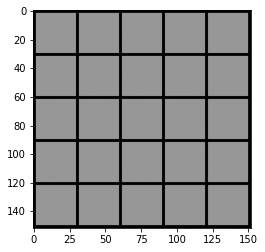

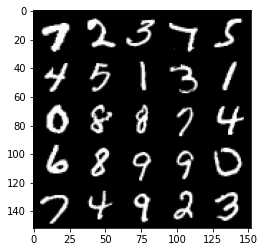

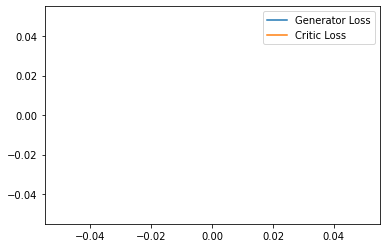

Step 6400: Generator loss: 55.93180480750538, critic loss: -308.7794349521119


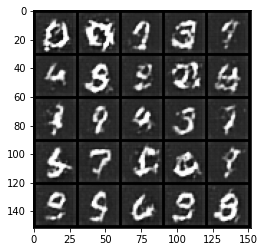

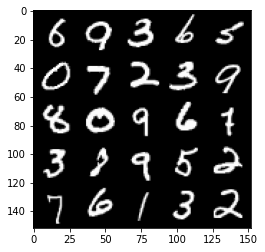

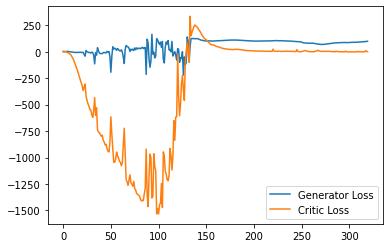

Step 12800: Generator loss: 299.658031668663, critic loss: -0.6905341023905214


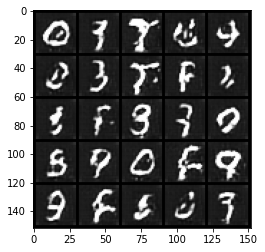

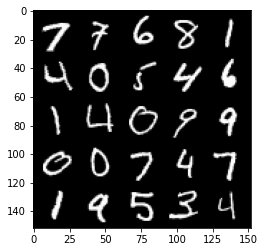

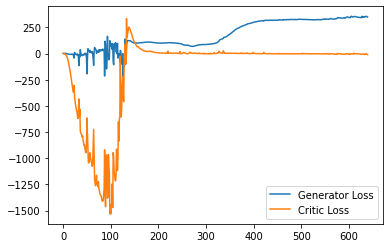

Step 19200: Generator loss: 343.62330944538115, critic loss: -6.019387136056108


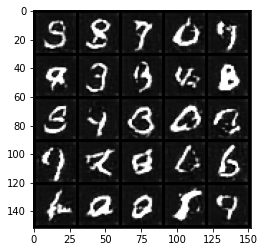

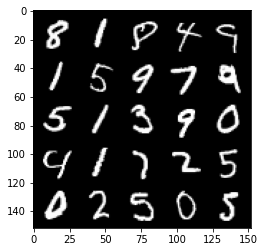

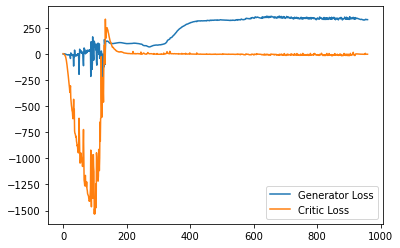

Step 25600: Generator loss: 307.26071558952333, critic loss: -2.577705962526618


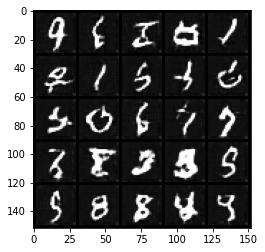

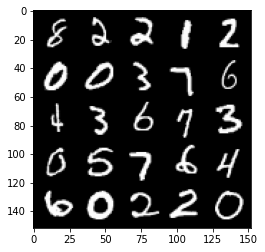

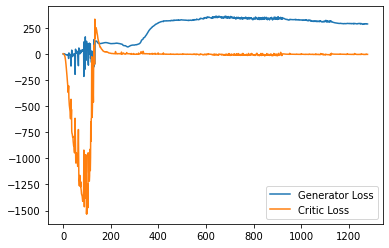

Step 32000: Generator loss: 268.7161209130287, critic loss: -2.682358033451032


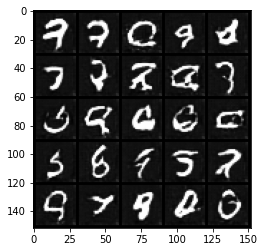

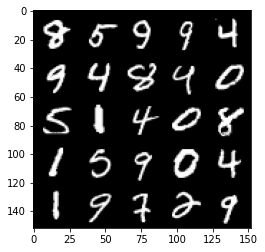

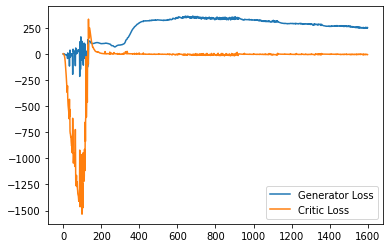

Step 38400: Generator loss: 257.0775122117996, critic loss: -4.280807107141948


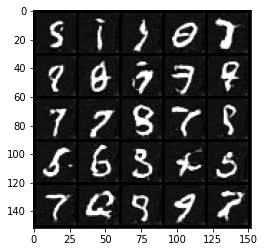

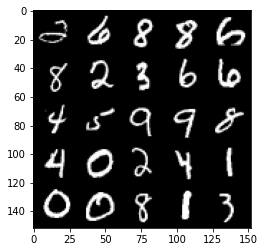

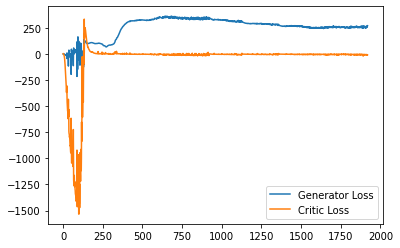

Step 44800: Generator loss: 250.71685325145722, critic loss: -5.963016974352299


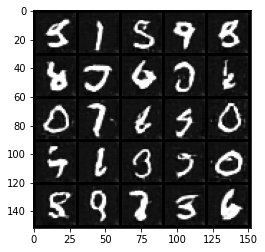

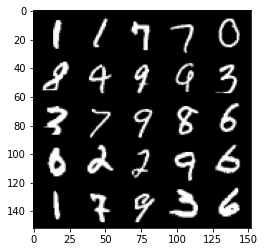

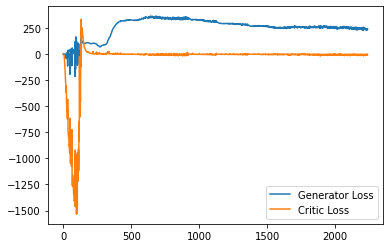

In [ ]:
import matplotlib.pyplot as plt

cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step >= 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1


## Conclusion WGAN-GP

The major advantage of WGAN-GP is its convergency. It makes training more stable and therefore easier to train. 

As WGAN-GP helps models to converge better, we can use a more complex model for the generator and the discriminator.


# Final Thoughts

**Conclusions:**
- What we did:
  - Implementation of WGAN and WGAN-GP.
  - Test this loss in learning MNIST digits with a complexe model (DCGAN).

- What we achieved:
  - Samples of relatively average quality in the case of WGAN and better in WGAN-GP.

- What we observe: 
  - **Wasserstein Loss correlates with the quality of generated image**, i.e. a lower Wasserstein loss produces samples of better quality (in contrast of BCE which is not informative).
  - Forcing Lipschitz constraint with weight clipping is a bad idea, instead use regularization and smooth the objective.
- What we encountred:
  - Need of additional parameter tuning for the clipping bound in case of WGAN . 
  - Instability in learning the WGAN, the learning curve improved with Gradient Penalty.

**Next Steps:**
- Study the **relation between $c$ in weight clipping the the Lipschitz constant $K$.**
- **Study whether the Wasserstein Loss approximates the Wasserstein distance (as a proxy) and benchmark against Sinkhorn divergence on 1D and 2D cases.** 
- Compare quantitatively using the inception score, as mentionned in the article.
- Compare the performance on a toyset with apparent mode to test mode collapse problem.
- Use batch normalization to try to reduce the instability during training. 
- Test with different model architectures (CNN, etc..).
- Benchmark against vanilla GANs with BCE loss.
